<a href="https://colab.research.google.com/github/bendemers/SE-Data-Science-Co-op-Technical/blob/main/NYC_AirBnB_Price_Predictor_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NYC AirBnb Price Preditor
By Ben Demers

Working with a [kaggle dataset](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data) provided by Airbnb to build a model that can predict price of a house in NY using the Airbnb dataset. 


# Data Exploration and Wrangling
The goal of this section is to take an intial look at the data set and begin make predictions/clean up to data so it can be fit to a regression model.

Import libraries  

In [26]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt

In [27]:
airbnb = pd.read_csv("AB_NYC_2019.csv")
airbnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [28]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [29]:
airbnb.duplicated().sum()

0

In [30]:
airbnb.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

We can see from viewing the sums of null entires in the dataframe that there are a few entires missing a name/host name and a larger subset of the data the is missing last reviews and reviews per month. After reading about the data, it seems that last reviews and reviews per month are null in the case of a listing have no reviews. For our model, we can just drop the coloums of 'name', 'id', 'host_name', and 'last_review' as those shouldn't have too much impact on the model and could be considered unethical in the case of host name as we don't want to fit out model towards the people listing the houses, only the houses themselves. We will then just replace the null entries of reviews per month with a zero.



In [31]:
airbnb.drop(['name', 'host_id', 'latitude', 'longitude', 'id', 'host_name', 'last_review'], axis=1, inplace= True)
airbnb.fillna({'reviews_per_month': 0}, inplace= True)
airbnb.head(3)

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,Private room,150,3,0,0.00,1,365


In [32]:
airbnb.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

Next, I want to check for outliers in the data, for example listings with extreme prices.

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64


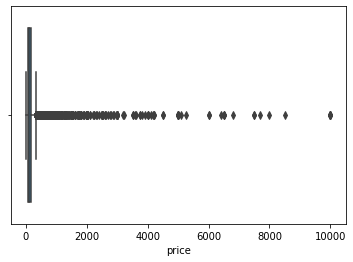

In [33]:
print(airbnb["price"].describe())
seaborn.boxplot(x=airbnb['price'])

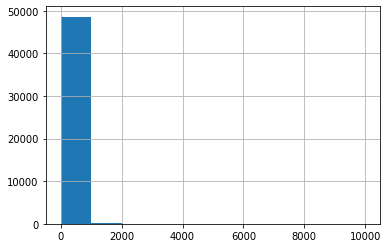

In [34]:
price_dist = airbnb['price'].hist()

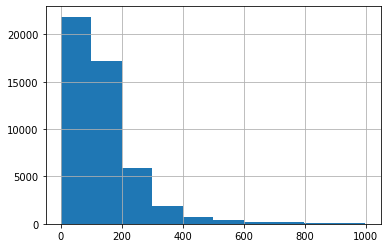

In [35]:
price_dist = airbnb['price'][airbnb['price'] < 1000].hist()

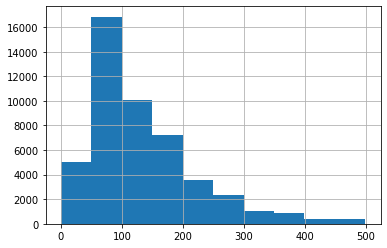

In [36]:
price_dist = airbnb['price'][airbnb['price'] < 500].hist()

We can see that the vast majority of the price data exists for prices under \$1000. We will remove all of the entries that are priced above \$1000 and try to account for the fact that there distrobution is more focused in the range of \$0-\$300.

In [37]:
airbnb[airbnb["price"] == 0].shape

(11, 9)

Weird to see that there are 11 listings at price zero, should be removed.

In [38]:
print(airbnb.shape)
airbnb = airbnb[airbnb["price"]<500]
airbnb = airbnb[airbnb["price"]>0]
print(airbnb.shape)

(48895, 9)
(47649, 9)


In [39]:
airbnb.groupby("neighbourhood_group")["price"].mean()

neighbourhood_group
Bronx             81.044403
Brooklyn         111.701958
Manhattan        161.114141
Queens            92.344583
Staten Island     91.144414
Name: price, dtype: float64

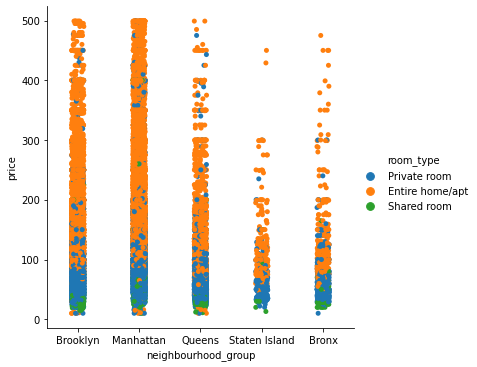

In [40]:
byNeighborhood = seaborn.catplot(data = airbnb, x = "neighbourhood_group", y = "price", kind = "strip", hue = "room_type")
byNeighborhood

In [41]:
print(airbnb.mean())
print(airbnb.std())

price                             130.083926
minimum_nights                      6.978006
number_of_reviews                  23.591492
reviews_per_month                   1.101467
calculated_host_listings_count      7.096812
availability_365                  111.016768
dtype: float64
price                              85.074554
minimum_nights                     20.339170
number_of_reviews                  44.871748
reviews_per_month                   1.604351
calculated_host_listings_count     32.825837
availability_365                  130.879436
dtype: float64


The standard deviation for minimun night stay of 20 seems high, as Airbnb is mostly for short term rentals.

In [42]:
airbnb['minimum_nights'].describe()

count    47649.000000
mean         6.978006
std         20.339170
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

Weird to see there is a max of a 1250 night stay

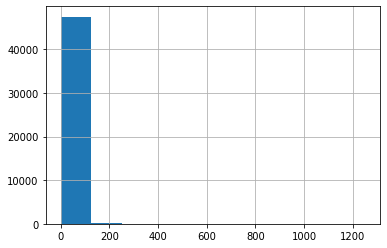

In [43]:
airbnb['minimum_nights'].hist()

0.25     1.00
0.50     2.00
0.75     5.00
0.95    30.00
0.99    43.52
Name: minimum_nights, dtype: float64


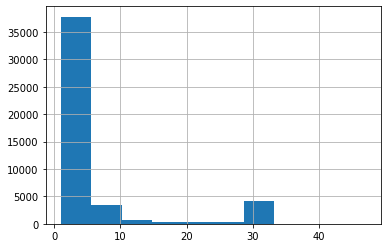

In [44]:
print(airbnb['minimum_nights'].quantile([0.25,0.5,0.75, .95, .99]))
airbnb[airbnb['minimum_nights'] < 50]['minimum_nights'].hist()

Of all of the reviews it seems that 30 nights makes sense as a place to cut off for miniumun night stay.

In [45]:
airbnb = airbnb[airbnb["minimum_nights"]<30]

Now I will visualize the possible corelation between varibles to help decide which model best fits our data using the heatmap function from the Seaborn library.

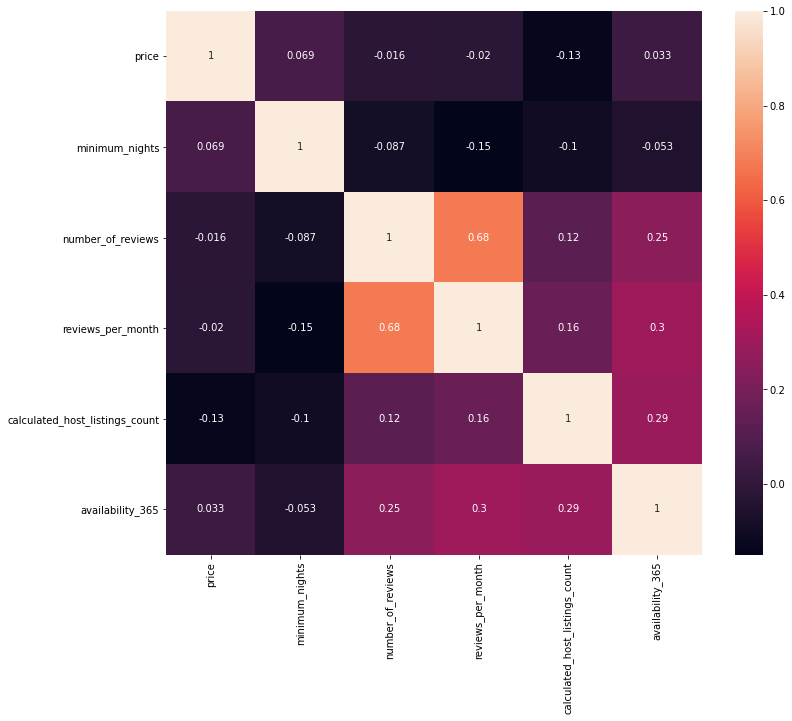

In [46]:
corrplot = airbnb.corr(method= 'kendall')
plt.figure(figsize= (12,10))
seaborn.heatmap(corrplot, annot=True)

From this plot, it seems that there is no strong correlation between any two varibles, which makes me predict early on that a ridge regression model will be a good fit as it takes all variables into account and weighs outliers less.

# Regression Methods and Comparisons

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost

## Preparing Data
Recoding non-numeric variables like neighborhood to interger values and spliting the data into test and train sets with price as the dependent variable for regression

In [48]:
print(airbnb.columns)

Index(['neighbourhood_group', 'neighbourhood', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')


Dropping neighbourhood and adding dummy values for neighbourhood_group to factorize it so the regression models can use it

In [49]:
airbnb = pd.get_dummies(airbnb, columns=['neighbourhood_group', 'neighbourhood', 'room_type'], prefix = ['ng',"nh","rt"], drop_first=True)
airbnb.head(3)

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,ng_Brooklyn,ng_Manhattan,ng_Queens,ng_Staten Island,nh_Arden Heights,nh_Arrochar,nh_Arverne,nh_Astoria,nh_Bath Beach,nh_Battery Park City,nh_Bay Ridge,nh_Bay Terrace,"nh_Bay Terrace, Staten Island",nh_Baychester,nh_Bayside,nh_Bayswater,nh_Bedford-Stuyvesant,nh_Belle Harbor,nh_Bellerose,nh_Belmont,nh_Bensonhurst,nh_Bergen Beach,nh_Boerum Hill,nh_Borough Park,nh_Breezy Point,nh_Briarwood,nh_Brighton Beach,nh_Bronxdale,nh_Brooklyn Heights,nh_Brownsville,nh_Bull's Head,nh_Bushwick,nh_Cambria Heights,nh_Canarsie,...,nh_South Slope,nh_Springfield Gardens,nh_Spuyten Duyvil,nh_St. Albans,nh_St. George,nh_Stapleton,nh_Stuyvesant Town,nh_Sunnyside,nh_Sunset Park,nh_Theater District,nh_Throgs Neck,nh_Todt Hill,nh_Tompkinsville,nh_Tottenville,nh_Tremont,nh_Tribeca,nh_Two Bridges,nh_Unionport,nh_University Heights,nh_Upper East Side,nh_Upper West Side,nh_Van Nest,nh_Vinegar Hill,nh_Wakefield,nh_Washington Heights,nh_West Brighton,nh_West Farms,nh_West Village,nh_Westchester Square,nh_Westerleigh,nh_Whitestone,nh_Williamsbridge,nh_Williamsburg,nh_Willowbrook,nh_Windsor Terrace,nh_Woodhaven,nh_Woodlawn,nh_Woodside,rt_Private room,rt_Shared room
0,149,1,9,0.21,6,365,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,225,1,45,0.38,2,355,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,150,3,0,0.00,1,365,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [50]:
x = airbnb.drop('price', axis=1)
y = airbnb['price']

In [51]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .20, random_state = 42)

## Ridge Regression

In [52]:
ridgeReg = Ridge(alpha=.01, normalize=True)
ridgeReg.fit(x_train, y_train)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=0.001)

## Lasso Regression

In [53]:
lassoReg = Lasso(alpha=0.001, normalize=False)
lassoReg.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6914890.077051118, tolerance: 24575.70352160375
  positive)


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

## Elastic Net Regression

In [54]:
elasticNetReg = ElasticNet(alpha= .01, normalize=False)
elasticNetReg.fit(x_train, y_train)

ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

## XGBoost

In [55]:
xgb = xgboost.XGBRegressor(n_estimators=310,learning_rate=0.1,objective='reg:squarederror')
xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=310,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

## Gradient Boost

In [56]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.01)
GBoost.fit(x_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

## Comparison and Metrics

I chose to use the three metrics of mean absolute error, root mean squared error, and the coefficient of determination, or the $R^2$ score. These metrics will give a good idea for if the model is getting close to the actual prices in the test data and a basic idea of what factors are influencing the outcomes, such as outliers.

In [57]:

print("==================Lasso=========================")
lassoPredictions = lassoReg.predict(x_test)
print("Mean Absolute Error: {mae: f}"
    .format(mae= metrics.mean_absolute_error(y_test, lassoPredictions)))
print("Root Mean Squared Error: {rmse: f}"
    .format(rmse=np.sqrt(metrics.mean_squared_error(y_test, lassoPredictions))))
print("R2: {r2: f}"
    .format(r2=metrics.r2_score(y_test, lassoPredictions)))
print("===================Ridge========================")
ridgePredictions = ridgeReg.predict(x_test)
print("Mean Absolute Error: {mae: f}"
    .format(mae= metrics.mean_absolute_error(y_test, ridgePredictions)))
print("Root Mean Squared Error: {rmse: f}"
    .format(rmse=np.sqrt(metrics.mean_squared_error(y_test, ridgePredictions))))
print("R2: {r2: f}"
    .format(r2=metrics.r2_score(y_test, ridgePredictions)))
print("================Elastic Net=====================")
elasticNetPrediction = elasticNetReg.predict(x_test)
print("Mean Absolute Error: {mae: f}"
    .format(mae= metrics.mean_absolute_error(y_test, elasticNetPrediction)))
print("Root Mean Squared Error: {rmse: f}"
    .format(rmse=np.sqrt(metrics.mean_squared_error(y_test, elasticNetPrediction))))
print("R2: {r2: f}"
    .format(r2=metrics.r2_score(y_test, elasticNetPrediction)))
print("===================XGB==========================")
gbmPredict = xgb.predict(x_test)
print("Mean Absolute Error: {mae: f}"
    .format(mae= metrics.mean_absolute_error(y_test, gbmPredict)))
print("Root Mean Squared Error: {rmse: f}"
    .format(rmse=np.sqrt(metrics.mean_squared_error(y_test, gbmPredict))))
print("R2: {r2: f}"
    .format(r2=metrics.r2_score(y_test, gbmPredict)))
print("==================GBoost========================")
gBoostPredict = GBoost.predict(x_test)
print("Mean Absolute Error: {mae: f}"
    .format(mae= metrics.mean_absolute_error(y_test, gBoostPredict)))
print("Root Mean Squared Error: {rmse: f}"
    .format(rmse=np.sqrt(metrics.mean_squared_error(y_test, gBoostPredict))))
print("R2: {r2: f}"
    .format(r2=metrics.r2_score(y_test, gBoostPredict)))


==================Lasso=========================
Mean Absolute Error:  41.578341
Root Mean Squared Error:  60.238604
R2:  0.475378
===================Ridge========================
Mean Absolute Error:  41.574830
Root Mean Squared Error:  60.273649
R2:  0.474767
================Elastic Net=====================
Mean Absolute Error:  41.854330
Root Mean Squared Error:  60.654174
R2:  0.468114
===================XGB==========================
Mean Absolute Error:  39.711403
Root Mean Squared Error:  58.343879
R2:  0.507861
==================GBoost========================
Mean Absolute Error:  39.895140
Root Mean Squared Error:  58.523830
R2:  0.504821


# Results and Takeaways

Based on these metrics, XGBoost preformed the best overall, the lost lowest MSE, RMSE, and greatest $R^2$ score. Gradient boosting was a close second with slightly higher MSE and RMSE and lower $R^2$ scores. As expected, both Lasso and Ridge preformed about the same. I expected Elastic Net preform to be slightly better than Lasso and Ridge but given the 200+ dummy variables for the neighborhoods it makes sense all three of these methods may struggle.